# Feature Selection
I decided from my `eda.ipynb` that an easy initial goal could be creating the entire feature selection, pipelines, feature extraction, model training flow for just one patient. That will make it simpler on me, and I can prototype/proof of concept my methods before extrapolating to the entire patient list.

With that being said, the chosen patient is `chb15`. They have the most ictal period state in seconds of all patients (~2000s). This python notebook will delve mostly into the file `data/chb15/chb15_06.edf` because it is the first file to have a seizure for that patient. 

### Goals 
- gain familiarity/comfort with extracting features from data
- extract various time-domain features (4+)
- learn to determine feature usefulness/quality for model prediction

### Notes on determining feature quality
1. visually inspect
  - boxplots
  - scatterplots
2. statistical tests
  - t-test (looking for p-values < 0.05)
3. correlation
  - calculate correlation between features and labels
4. model-based evaluation
create a quick/small model on a subset of the data (only one or couple features) and assess performance metrics like
  - Accuracy
  - ROC-AUC
  - Feature importance (tree based models)
  - PCA (looking at the eigenvector and matching that to the features)

In [1]:
import mne

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from extraction.tools import get_all_seizures, get_seizure_path

### Ictal vs Interictal Comparison


In [5]:
# Load up data... chb15_06.edf
filename = '../data/chb15/chb15_06.edf'
raw = mne.io.read_raw_edf(filename, preload=True)
raw.drop_channels(['--0', '--1', '--2', '--3', '--4', '--5'])   # dud channels?

ictal_start, ictal_end = 272, 397
interictal_start, interictal_end = 850, 976     # randomly choosing a non seizure time frame = length of seizure time

# crop desired times, filter out excess freqs/noise (bandpass 1-50hz)
ictal = raw.copy().crop(tmin=ictal_start, tmax=ictal_end).filter(l_freq=1, h_freq=50, verbose=False)
interictal = raw.copy().crop(tmin=interictal_start, tmax=interictal_end).filter(l_freq=1, h_freq=50, verbose=False)

Extracting EDF parameters from /home/kimbo/github-repos/chb-mit-scalp-eeg/data/chb15/chb15_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


/tmp/ipykernel_3057969/3021436279.py:3: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(filename, preload=True)
/tmp/ipykernel_3057969/3021436279.py:3: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(filename, preload=True)


#### A. Ictal vs interictal PSD
- After comparing the PSD's, keeping my eye on two frequency bands
  - 10-15Hz
  - 20-25Hz

Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).


/tmp/ipykernel_2935591/3255378401.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  ictal.compute_psd(fmax=60).plot()


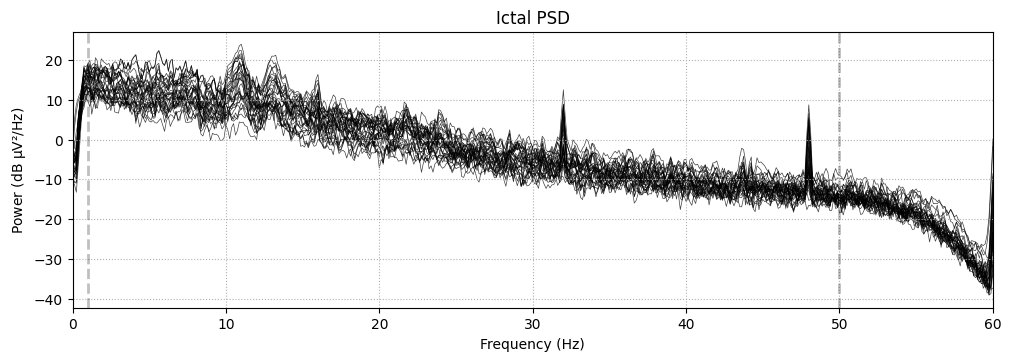

Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).


/tmp/ipykernel_2935591/3255378401.py:5: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  interictal.compute_psd(fmax=60).plot()


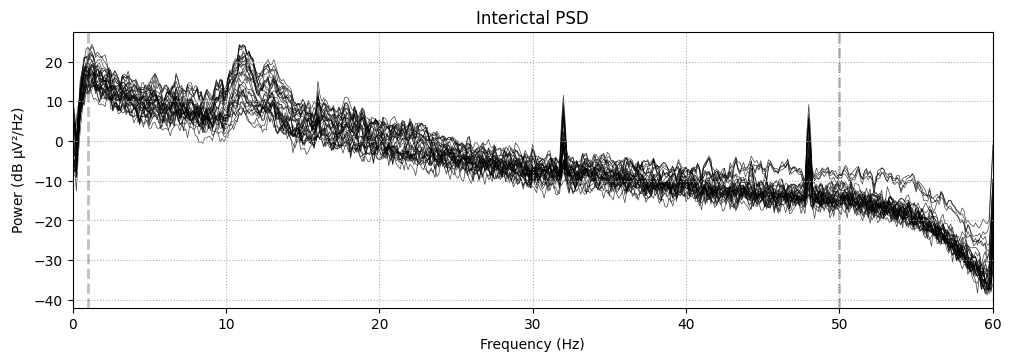

In [12]:
ictal.compute_psd(fmax=60).plot()
plt.title('Ictal PSD')
plt.show()

interictal.compute_psd(fmax=60).plot()
plt.title('Interictal PSD')
plt.show()

### Time-Domain Features
Possible Features to extract: Mean, Variance (VAR), standard deviation, MAV, skewness, Kurtosis, Hjorth parameters, zero crossing rate

But for now I'll focus on:
- mean
- VAR
- MAV
- skewness _(Skewness measures the asymmetry of a distribution)_
- kurtosis _(Kurtosis quantifies the "tailedness" of a distribution. A high kurtosis value indicates a distribution with heavier tails (more outliers))_

#### Data Preparation

I realize we need to polish the data before we can even extract any features. I'd say this process is akin to going from bronze -> silver quality of data.
- data annotation
- data segmentation (use a window size and overlap)
- label generation (creating a vector of the target class that is |Segments| x 1 size)

In [66]:
# Annotate the data
'''
Note: we are only working with one file, and this file only has 1 seizure, so I am manually setting the annotations.
use this as a starting point for later in the project to have a script that can automate this process
'''
onsets = []
durations = []
descriptions = []
onsets.append(272) 
durations.append(397 - 272)  # end time - start time
descriptions.append("ictal")

annotations = mne.Annotations(onset=onsets, duration=durations, description=descriptions)

raw.set_annotations(annotations)    # I only set so it doesn't output the metadata

<RawEDF | chb15_06.edf, 32 x 921600 (3600.0 s), ~225.0 MiB, data loaded>

In [40]:
# segment the data
WINDOW_SIZE = 2  # in seconds
OVERLAP = (0.25) * WINDOW_SIZE   # ALSO in seconds... doing it like this so I can just set as a % of windowsize

epochs = mne.make_fixed_length_epochs(raw, duration=WINDOW_SIZE, overlap=OVERLAP, preload=True)
print('total segments:', len(epochs))

Not setting metadata
2399 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2399 events and 512 original time points ...
0 bad epochs dropped
total segments: 2399


In [42]:
# Create label vector 
sfreq = raw.info["sfreq"]   # get sampling frequency
labels = []

for x in range(len(epochs.events[:, 0])):
    # using sampling freq, get start time and end time of a segment
    t0 = epochs.events[x, 0] / sfreq
    t1 = t0 + epochs.tmax
    # if there is ANY overlap of a seizure period and this segment, label = 1
    is_seizure = any(
        (ann["onset"] < t1) and (ann["onset"] + ann["duration"] > t0)
        for ann in raw.annotations if 'ictal' in ann["description"].lower()
    )
    labels.append(int(is_seizure))

print('total target segments:',sum(labels))   # rough check on how many segments overlap with ictal period
print(f'% of segments that are class=1 (ictal): {sum(labels)/len(labels)*100:.2f}%')

total target segments: 84
% of segments that are class=1 (ictal): 3.50%


#### Mean Extraction

List of channels:
FP1-F7, F7-T7, T7-P7, P7-O1, FP1-F3, F3-C3, C3-P3, P3-O1, FZ-CZ, CZ-PZ, PZ-OZ, FP2-F4, F4-C4, C4-P4, P4-O2, FP2-F8, F8-T8, T8-P8-0, P8-O2, P7-T7, 
T7-FT9, FT9-FT10, FT10-T8, T8-P8-1, FC1-Ref, FC2-Ref, FC5-Ref, FC6-Ref, CP1-Ref, CP2-Ref, CP5-Ref, CP6-Ref

- Upon a brief inspection I see no significance in the mean being a predictor of ictal states, I wasn't too keen on this feature being informative, but we shall see the outcome of the feature analysis

In [44]:
# Extracting mean per epoch (segment), per channel
data = epochs.get_data()  # shape: (n_epochs, n_channels, n_times)
means_per_epoch = data.mean(axis=2)  # shape: (n_epochs, n_channels)

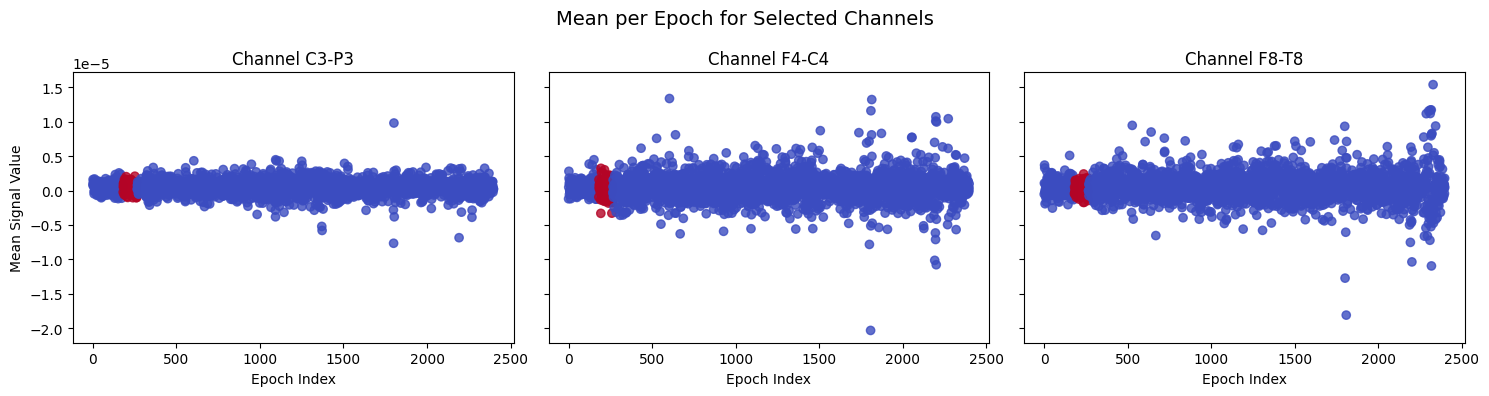

'\nList of channels:\nFP1-F7, F7-T7, T7-P7, P7-O1, FP1-F3, F3-C3, C3-P3, P3-O1, FZ-CZ, CZ-PZ, PZ-OZ, FP2-F4, F4-C4, C4-P4, P4-O2, FP2-F8, F8-T8, T8-P8-0, P8-O2, P7-T7, \nT7-FT9, FT9-FT10, FT10-T8, T8-P8-1, FC1-Ref, FC2-Ref, FC5-Ref, FC6-Ref, CP1-Ref, CP2-Ref, CP5-Ref, CP6-Ref\n'

In [67]:
# scatter plots to show means of every segment over time, 
channels_to_plot = [6, 12, 16]  # Change this list to plot different channels
n_channels = len(channels_to_plot)

fig, axes = plt.subplots(1, n_channels, figsize=(5 * n_channels, 4), sharey=True)

for i, ch in enumerate(channels_to_plot):
    ax = axes[i]
    scatter = ax.scatter(
        range(len(means_per_epoch[:, ch])),  # X-axis: epoch index
        means_per_epoch[:, ch],              # Y-axis: mean for channel ch
        c=labels, cmap="coolwarm", alpha=0.8 # Color by label
    )
    ax.set_title(f"Channel {raw.ch_names[ch]}")
    ax.set_xlabel("Epoch Index")
    if i == 0:
        ax.set_ylabel("Mean Signal Value")

fig.suptitle("Mean per Epoch for Selected Channels", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# plot the mean
df = pd.DataFrame({
    "MeanValue": means_per_epoch[:, 3],  # arbitratrily choosing a channel's means to plot
    "Label": labels
})
df["Label"] = df["Label"].map({0: "Non-Seizure", 1: "Seizure"})

plt.figure(figsize=(8, 5))
# sns.boxplot(x="Label", y="MeanValue", data=df)
sns.histplot(data=df, x="MeanValue", hue="Label")
plt.title("Mean Feature per Epoch by Label")
plt.ylabel("Mean Signal Value")
plt.xlabel("Label")
plt.grid(True)
plt.show()